In [1]:
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd

In [2]:
SELECTED_DATA = os.path.join('data', 'selected_dataset')
ORIGINAL_DATA = os.path.join('data', 'cleaned_dataset')
PROCESSED_DATASET = os.path.join('data', 'processed_dataset')
SAMPLE_IMAGE = 'data/selected_dataset/normal/DSC03990_5.JPG'

In [3]:
model = ResNet50(weights='imagenet', include_top=False)

In [25]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [24]:
model.layers[-4].get_weights()

[array([[[[ 1.76406968e-02,  2.18379945e-02,  6.38491847e-03, ...,
           -1.56918354e-02,  1.33828130e-02, -7.58931879e-03],
          [ 6.57748384e-03, -1.13832625e-02, -1.44122150e-02, ...,
            1.07535999e-02,  1.99317057e-02, -5.90330362e-03],
          [ 1.96981058e-02,  6.84878789e-03, -1.30715151e-03, ...,
           -8.99719913e-03,  1.00973761e-02, -1.09837623e-02],
          ...,
          [ 4.02560830e-03, -2.51277094e-03, -1.91410668e-02, ...,
            1.84022412e-02, -1.05592925e-02,  3.84159223e-03],
          [-1.21582337e-02, -2.44973949e-03, -8.21000524e-03, ...,
           -3.52650182e-03,  9.62345582e-03, -1.55217517e-02],
          [-1.57500952e-02, -5.96316298e-03,  4.53999359e-03, ...,
            4.88574570e-03,  4.60040662e-03,  8.99072620e-05]]]],
       dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)]

## Sample Image

In [7]:
from PIL import Image
import matplotlib.pyplot as plt


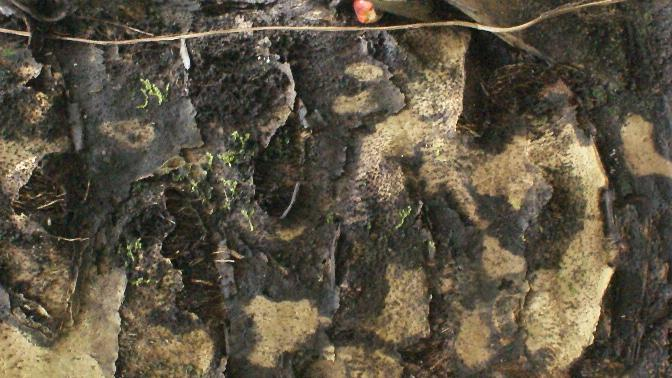

In [8]:
Image.open(SAMPLE_IMAGE)

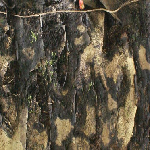

In [26]:
image = load_img(SAMPLE_IMAGE, target_size=(150, 150))
image

In [9]:
image = load_img(SAMPLE_IMAGE, target_size=(150, 150))
image = img_to_array(image)
image = preprocess_input(image)

feature_maps = model.predict(np.array([image]))
feature_maps.shape

1/1 [==============================] - 0s 83ms/step


(1, 5, 5, 2048)

In [14]:
feature_maps[0, :, :, 0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.34661257, 0.908517  , 1.6740174 , 0.10149181],
       [0.        , 0.        , 0.        , 0.22695863, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]],
      dtype=float32)

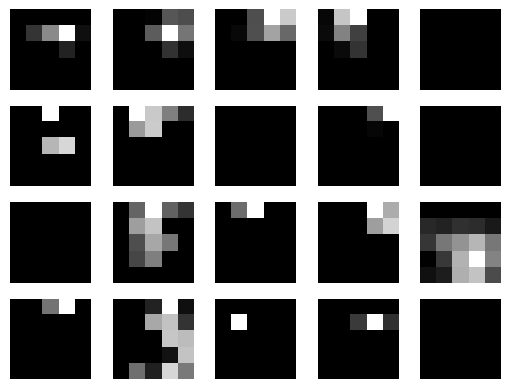

In [19]:
# plot first 20 filters
n_filters = 20
# specify subplot and turn of axis
fig, ax = plt.subplots(4, 5)

# show the first 20 feature map
for i in range(n_filters):
    # specify subplot and turn of axis
    ax[i//5, i%5].imshow(feature_maps[0, :, :, i], cmap='gray')
    ax[i//5, i%5].axis('off')


In [6]:
feature_map[0, :, :, 0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.34661257, 0.908517  , 1.6740174 , 0.10149181],
       [0.        , 0.        , 0.        , 0.22695863, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]],
      dtype=float32)

In [27]:
def extract_and_export(image_path, export_name):
    batch_images = []
    label = []
    class_map = {'normal': 0, 'infected': 1}
    for image_class in os.listdir(image_path):
        class_path = os.path.join(image_path, image_class)
        for image_file in os.listdir(class_path):
            # print(os.path.join(class_path, image_file))
            image = load_img(os.path.join(class_path, image_file), target_size=(150, 150))
            image = img_to_array(image)
            image = preprocess_input(image)
            batch_images.append(image)
            label.append(class_map[image_class])

    batch_images = np.array(batch_images)
    features = model.predict(batch_images)
    features = features.reshape((-1, 5*5*2048))

    features_df = pd.DataFrame(features,
                               columns=[f'resnet_{x+1}' for x in range(features.shape[-1])])
    # features_df['is_infected'] = label
    features_df.to_csv(os.path.join('data', export_name+'.csv'), index=False)
    features_df.to_parquet(os.path.join('data', export_name+'.csv'), index=False)
    # features_df.to_excel(os.path.join('data', 'excel', export_name+'.xlsx'), index=False)
    return features_df

In [58]:
orig_df = extract_and_export(SELECTED_DATA, 'orig_img_feature')

63/63 [==============================] - 52s 804ms/step


ValueError: This sheet is too large! Your sheet size is: 2000, 51201 Max sheet size is: 1048576, 16384

In [30]:
orig_df = extract_and_export(SELECTED_DATA, 'orig_img_feature')

data\selected_dataset\infected\DSC03977_6.JPG
data\selected_dataset\infected\DSC03979_6.JPG
data\selected_dataset\infected\DSC03980_4.JPG
data\selected_dataset\infected\DSC03980_5.JPG
data\selected_dataset\infected\DSC03980_9.JPG
data\selected_dataset\infected\DSC03983_4.JPG
data\selected_dataset\infected\DSC03984_4.JPG
data\selected_dataset\infected\DSC03984_6.JPG
data\selected_dataset\infected\DSC03986_5.JPG
data\selected_dataset\infected\DSC03987_5.JPG
data\selected_dataset\infected\DSC03990_4.JPG
data\selected_dataset\infected\DSC03992_5.JPG
data\selected_dataset\infected\DSC03997_6.JPG
data\selected_dataset\infected\DSC03997_9.JPG
data\selected_dataset\infected\DSC03998_9.JPG
data\selected_dataset\infected\DSC04002_6.JPG
data\selected_dataset\infected\DSC04002_8.JPG
data\selected_dataset\infected\DSC04002_9.JPG
data\selected_dataset\infected\DSC04004_3.JPG
data\selected_dataset\infected\DSC04004_5.JPG
data\selected_dataset\infected\DSC04004_6.JPG
data\selected_dataset\infected\DSC

In [34]:
extracted_feature = pd.read_csv('data/orig_img_feature.csv')
extracted_feature.head()

,resnet_1,resnet_2,resnet_3,resnet_4,resnet_5,resnet_6,resnet_7,resnet_8,resnet_9,resnet_10,...,resnet_51191,resnet_51192,resnet_51193,resnet_51194,resnet_51195,resnet_51196,resnet_51197,resnet_51198,resnet_51199,resnet_51200
0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.028299,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,1.585785,0.0,3.971417,1.891622,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.213993,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [32]:
print('ho')

ho


In [60]:
proc_df = extract_and_export(PROCESSED_DATASET, 'processed_img_feature')

63/63 [==============================] - 51s 808ms/step


In [61]:
proc_df

,resnet_1,resnet_2,resnet_3,resnet_4,resnet_5,resnet_6,resnet_7,resnet_8,resnet_9,resnet_10,...,resnet_51191,resnet_51192,resnet_51193,resnet_51194,resnet_51195,resnet_51196,resnet_51197,resnet_51198,resnet_51199,resnet_51200
0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.886713,0.0,0.000000,0.000000,0.0
1,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.846535,0.069445,0.0
2,0.604842,0.0,0.916294,0.900313,0.0,0.205639,0.966447,0.0,0.000000,0.425253,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
3,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
4,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
1996,0.000000,0.0,0.051989,0.761638,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,2.592691,0.0
1997,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,3.585832,0.073563,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
1998,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
